<a href="https://colab.research.google.com/github/Martinovdima/-Python/blob/master/MartinSep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project "MartinSep"
Проект по разделению аудиофайлов на вокал и аккомпанемент. Будет использоваться датасет MUSDB18 и модель U-Net.


# Этап 1. Подготовка данных.
Конечная цель этого этапа - подготовить данные для обучения модели разделения голоса и музыки (vocal/accompaniment separation). Я выделил для себя несколько этапов:

1. Преобразование в монофонический формат:
Для анализа и обработки аудиозаписей мы будем использовать монофонический формат, где звук воспроизводится через один канал (моно), а не через два (стерео). Это позволит упростить подход к подготовке данных. Мы будем преобразовать стерео-звук в монофонический формат, путем усреднения значений звуковых сигналов двух каналов. При помощи библиотеки *Numpy* и методу *mean*.

2. Разделение на короткие участки:
Для обучения модели мы будим разбивать аудиозаписи на более короткие участки, так как это увеличит количество обучающих примеров и улучшит обобщающую способность модели. Я буду разделять участки по 1 секунде.

3. Создание спектограмм:
Для подачи данных в сеть мы преобразуем каждый участок аудиофайла длительностью в 1 секундк в спектограммы размером 256х256, таком образом у нас должен получиться тензор размером (None, 256, 256).

4. Разделение на подмножества:
Конечный этап будет разделение данных на три подмножества mixin, vocal, accompaniment.

В итоге мы должны получить:
x_train - нормированные спектограммы mixin размером 256х256, 90% данных.
x_val - нормированные спектограммы mixin размером 256х256, 10% данных.

y_train - нормированные спектограммы accompaniment размером 256х256, 90% данных.
y_val - нормированные спектограммы accompaniment размером 256х256, 10% данных.


In [1]:
#@title **connect google drive**
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
#@title **unzip files dataset**
!unzip /content/drive/MyDrive/MUSDB/musdb18.zip

Archive:  /content/drive/MyDrive/MUSDB/musdb18.zip
  inflating: README.md               
   creating: test/
  inflating: test/Al James - Schoolboy Facination.stem.mp4  
  inflating: test/AM Contra - Heart Peripheral.stem.mp4  
  inflating: test/Angels In Amplifiers - I'm Alright.stem.mp4  
  inflating: test/Arise - Run Run Run.stem.mp4  
  inflating: test/Ben Carrigan - We'll Talk About It All Tonight.stem.mp4  
  inflating: test/BKS - Bulldozer.stem.mp4  
  inflating: test/BKS - Too Much.stem.mp4  
  inflating: test/Bobby Nobody - Stitch Up.stem.mp4  
  inflating: test/Buitraker - Revo X.stem.mp4  
  inflating: test/Carlos Gonzalez - A Place For Us.stem.mp4  
  inflating: test/Cristina Vane - So Easy.stem.mp4  
  inflating: test/Detsky Sad - Walkie Talkie.stem.mp4  
  inflating: test/Enda Reilly - Cur An Long Ag Seol.stem.mp4  
  inflating: test/Forkupines - Semantics.stem.mp4  
  inflating: test/Georgia Wonder - Siren.stem.mp4  
  inflating: test/Girls Under Glass - We Feel Alright.s

In [3]:
#@title **install stempeg**
!pip install stempeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 11.4 MB/s eta 0:00:00


In [4]:
#@title **import library**
import stempeg
import os
import numpy as np
import librosa                            # Параметризация аудио
import librosa.display                    # Визуализация аудио
import matplotlib.pyplot as plt           # Отрисовка графиков
# Нормирование сигнала
from sklearn.preprocessing import minmax_scale, scale

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
#@title **Определение параметров**
TRAIN_PATH = '/content/train' # Путь к файлам обучающим
TEST_PATH = '/content/test' # Путь к файлам тестовым
TRAIN = sorted(os.listdir(TRAIN_PATH))
TEST = sorted(os.listdir(TEST_PATH))
COUNT_TRAIN = len(os.listdir(TRAIN_PATH))
COUNT_TEST = len(os.listdir(TEST_PATH))
output_mixture_folder = "./datasets/train/mixture"  # Папка для сохранения обработанных файлов
output_accompaniment_folder = "./datasets/train/accompaniment" # Папка для сохранения обработанных файлов
COMBINE_CHANNELS = [1, 2, 3]  # Каналы разделения датасета
N_FFT=511


In [6]:
def stft(audio_data):
  # Преобразование аудио в спектрограмму
  spectrogram = librosa.stft(audio_data, n_fft=N_FFT)

  # Размер каждой части (256x256)
  segment_size = (256, 256)

  # Разделение спектрограммы на части
  segments = []
  for i in range(0, spectrogram.shape[1] - segment_size[1] + 1, segment_size[1]):
    segment = spectrogram[:, i:i + segment_size[1]]
    segments.append(segment)

    # Преобразование в numpy массив
  segments = np.array(segments)
  print(f'Succes track {audio_data} !')
  return segments

In [7]:
def file_separation(filename, path):

  if filename.endswith('.stem.mp4'):
      input_file = os.path.join(path, filename)
      audio, rate = stempeg.read_stems(input_file)
      # Объединение выбранных каналов и усреднение, если каналы имеют разные размерности
      combined_data = np.mean([audio[channel_idx] for channel_idx in COMBINE_CHANNELS], axis=0)

      # Преобразование входных данных в тензоры и изменение формата
      mixtur = np.mean(audio[0], axis=-1)
      accompaniment = np.mean(combined_data, axis=-1)
      print(f'Succes {filename} !')
      return mixtur, accompaniment

In [8]:
#@title **Разделение и преобразование в спектры с выводом датасета**
def make_data(data, path, count):
  x = []
  y = []

  # Создаем папки, если они не существуют
  os.makedirs(output_mixture_folder, exist_ok=True)
  os.makedirs(output_accompaniment_folder, exist_ok=True)

  for dt in data[:count]:
    print(f'Processing {dt}')
    train_mixtur, train_accompaniment = file_separation(dt, path)
    x.append(stft(train_mixtur))
    y.append(stft(train_accompaniment))

  x_data = np.concatenate(x, axis=0)
  y_data = np.concatenate(y, axis=0)

  return x_data, y_data

In [ ]:
  #@title **Получение спектра и сохранения файлов**
  def save_data(data, path, count):
    # Создаем папки, если они не существуют
    os.makedirs(output_mixture_folder, exist_ok=True)
    os.makedirs(output_accompaniment_folder, exist_ok=True)

    for dt in data[:count]:
      print(f'Processing {dt}')
      train_mixtur, train_accompaniment = file_separation(dt, path)
      x = stft(train_mixtur)
      y = stft(train_accompaniment)
      np.save(os.path.join(output_mixture_folder, dt), x)
      np.save(os.path.join(output_accompaniment_folder, dt), y)
      print(f'Save {dt}')



In [ ]:
#@title **Загрузка сохраненных файлов и конкатенация их**
def make_datasets(data, path, count):
  save_data(data, path, count)
  x = []
  y = []

  # Пройдите по всем файлам в папке
  for filename in os.listdir(output_mixture_folder):
    if filename.endswith('.npy'):
      # Загрузите данные из файла и добавьте их в список
      file_path = os.path.join(output_mixture_folder, filename)
      print(f'Load {filename}')
      data = np.load(file_path, allow_pickle=True)
      x.append(data)
      print(f'Append {filename}')
    # Пройдите по всем файлам в папке
  for filename in os.listdir(output_accompaniment_folder):
    if filename.endswith('.npy'):
      # Загрузите данные из файла и добавьте их в список
      file_path = os.path.join(output_accompaniment_folder, filename)
      print(f'Load {filename}')
      data = np.load(file_path, allow_pickle=True)
      y.append(data)
      print(f'Append {filename}')

  # Объедините данные в один массив
  x = np.concatenate(data_list, axis=0)
  y = np.concatenate(data_list, axis=0)
  return x, y
  print(type(x))
  print(x.shape)
  print(type(y))
  print(y.shape)

In [10]:
x_train, y_train = make_data(TRAIN, TRAIN_PATH, 5)

Processing A Classic Education - NightOwl.stem.mp4
Succes A Classic Education - NightOwl.stem.mp4 !
Succes track [8.88658885e-03 2.45217411e-02 4.59328387e-02 ... 9.94882521e-06
 9.56205690e-06 9.83033055e-06] !
Succes track [-1.11389160e-03  1.09895236e-03  3.39451471e-03 ...  1.00669835e-06
 -7.44515447e-07 -7.46542289e-07] !
Processing ANiMAL - Clinic A.stem.mp4
Succes ANiMAL - Clinic A.stem.mp4 !
Succes track [-3.37682081e-07 -1.38342443e-06  1.71617518e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] !
Succes track [-1.12560694e-07 -4.61141478e-07  5.72058392e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] !
Processing ANiMAL - Easy Tiger.stem.mp4
Succes ANiMAL - Easy Tiger.stem.mp4 !
Succes track [ 2.35528832e-02  2.78132670e-02  2.35136831e-02 ... -2.14955662e-06
 -3.96860878e-06 -2.14853020e-06] !
Succes track [ 7.92454478e-03  9.29854690e-03  7.75096140e-03 ... -6.10390707e-07
 -6.48323657e-07 -1.77703689e-07] !
Processing ANiMAL - Rockshow.stem.mp4
Succes A

In [11]:
print(type(x_train))
print(x_train.shape)
print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(1322, 256, 256)
<class 'numpy.ndarray'>
(1322, 256, 256)


In [12]:
x_train_real = np.real(x_train)
y_train_real = np.real(y_train)
x_train_reshaped = x_train_real.reshape(x_train_real.shape[0], -1)
y_train_reshaped = y_train_real.reshape(y_train_real.shape[0], -1)

In [13]:
print(type(x_train_reshaped))
print(x_train_reshaped.shape)
print(type(y_train_reshaped))
print(y_train_reshaped.shape)

<class 'numpy.ndarray'>
(1322, 65536)
<class 'numpy.ndarray'>
(1322, 65536)


In [14]:
# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import StandardScaler
# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# класс для использования Functional API
from tensorflow.keras import Model

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils

In [15]:
# Создайте скалировщик
scaler = StandardScaler()

# Примените скалировщик к данным x_train и y_train
x_train_data_scaled = scaler.fit_transform(x_train_reshaped)
y_train_data_scaled = scaler.transform(y_train_reshaped)

In [16]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data_scaled,test_size=0.1)

In [17]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(1189, 65536) float64
(1189, 65536) float64

(133, 65536) float64
(133, 65536) float64


In [18]:
# Изменение формы и преобразование типа данных для обучающей выборки
x_train = x_train.reshape((x_train.shape[0], 256, 256, 1)).astype(np.float32)
y_train = y_train.reshape((y_train.shape[0], 256, 256, 1)).astype(np.float32)

# Изменение формы и преобразование типа данных для проверочной выборки
x_val = x_val.reshape((x_val.shape[0], 256, 256, 1)).astype(np.float32)
y_val = y_val.reshape((y_val.shape[0], 256, 256, 1)).astype(np.float32)

In [19]:
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

    # Возврат готовой модели
    return model

In [20]:
# Сборка автокодировщика для формы картинок датасета
ae_mnist = create_base_ae(x_train.shape[1:])

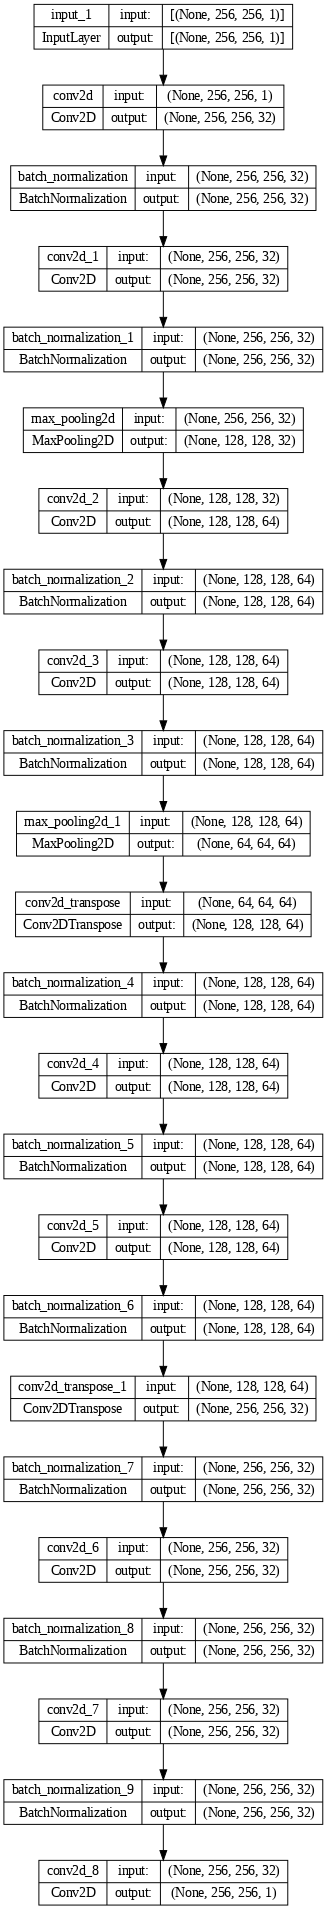

In [21]:
# Отображение модели
utils.plot_model(ae_mnist, show_shapes=True, dpi=70)

In [22]:
# Обучение модели автокодировщика, на входе и выходе одни и те же данные
history = ae_mnist.fit(x_train, x_train,
                       epochs=80,
                       batch_size=32,
                       validation_data = (x_val, y_val))

Epoch 1/80
38/38 [==============================] - 39s 448ms/step - loss: 1.2444 - val_loss: 0.3422
Epoch 2/80
38/38 [==============================] - 15s 408ms/step - loss: 1.1564 - val_loss: 0.2630
Epoch 3/80
38/38 [==============================] - 16s 408ms/step - loss: 1.0981 - val_loss: 0.2269
Epoch 4/80
38/38 [==============================] - 16s 418ms/step - loss: 1.0616 - val_loss: 0.2111
Epoch 5/80
38/38 [==============================] - 16s 427ms/step - loss: 1.0337 - val_loss: 0.2075
Epoch 6/80
38/38 [==============================] - 16s 422ms/step - loss: 1.0109 - val_loss: 0.2111
Epoch 7/80
38/38 [==============================] - 16s 414ms/step - loss: 0.9920 - val_loss: 0.2146
Epoch 8/80
38/38 [==============================] - 16s 413ms/step - loss: 0.9766 - val_loss: 0.2197
Epoch 9/80
38/38 [==============================] - 16s 416ms/step - loss: 0.9634 - val_loss: 0.2213
Epoch 10/80
38/38 [==============================] - 16s 418ms/step - loss: 0.9519 - val_lo

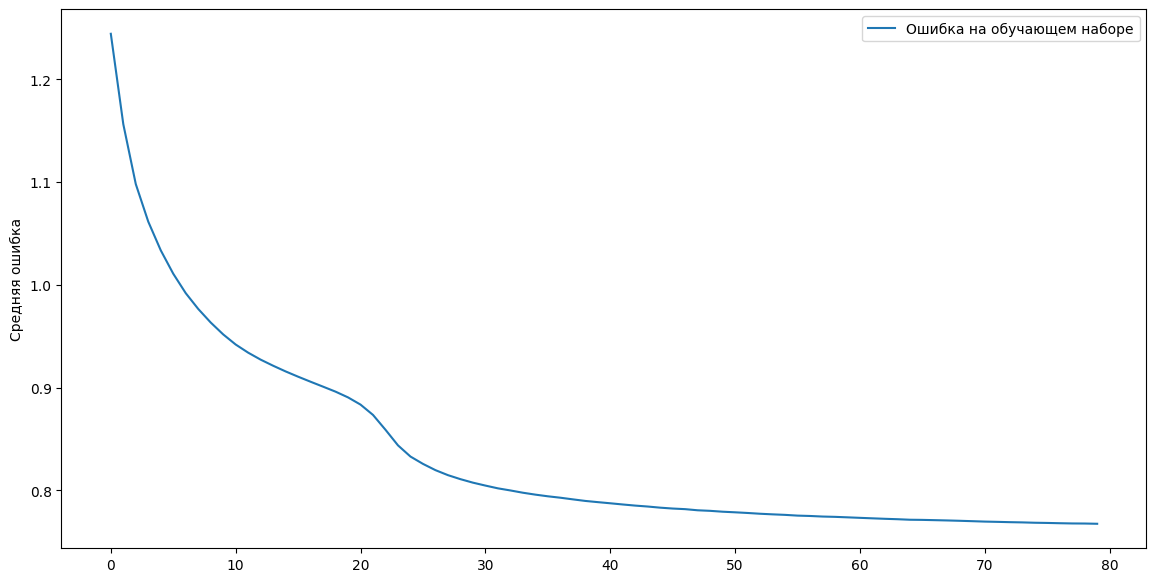

In [23]:
# Вывод графика процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# Создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [ ]:
# Сохранение/восстановление всей модели
ae_faces.save(PATH + 'ae_faces') # Сохраняем модель
ae_faces = load_model(PATH + 'ae_faces') # Загружаем модель